In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.v2 import ToTensor
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
transform_train = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomCrop(32, padding=4),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomRotation(15),
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
transform_test = v2.Compose([
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
trainset = datasets.CIFAR100(root = './data', train = True, download= True, transform = transform_train)
testset = datasets.CIFAR100(root = './data', train = False, download= True, transform = transform_test)

train_size = int(0.8* len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = False)
test_loader = DataLoader(testset, batch_size = 64, shuffle = False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 169M/169M [00:07<00:00, 23.2MB/s]


In [4]:
def train_dataloader_model(
    model, train_loader, valid_loader, optim, loss_fn,
    device=None, max_epochs=100, diff=1e-3, patience=5
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    valid_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # ----------------------------
        # TRAINING PHASE
        # ----------------------------
        model.train()
        running_train_loss = 0.0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optim.zero_grad()
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optim.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # ----------------------------
        # VALIDATION PHASE
        # ----------------------------
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_pred = model(X_valid)

                # Compute validation loss
                loss = loss_fn(y_pred, y_valid)
                running_valid_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(y_pred, 1)
                correct += (predicted == y_valid).sum().item()
                total += y_valid.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        epoch_valid_acc = correct / total

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        scheduler.step(epoch_valid_loss)
        # ----------------------------
        # EARLY STOPPING CHECKS
        # ----------------------------
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < diff:
            print(f"epoch {epoch}: loss diff < {diff} → early convergence.")
            break

        if epoch_valid_loss < valid_loss_min - diff:
            valid_loss_min = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        print(
            f"Epoch [{epoch+1}/{max_epochs}] | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Valid Loss: {epoch_valid_loss:.4f} | "
            f"Valid Acc: {epoch_valid_acc*100:.2f}%"
        )

        if patience_counter >= patience:
            print(f"\nEarly stopping: no improvement for {patience} epochs.")
            break

    # ----------------------------
    # PLOTTING BEFORE RETURN
    # ----------------------------
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, valid_losses, valid_accuracies


In [5]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels), nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias = False))

In [6]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels + i * growth_rate, growth_rate))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [7]:
def transition_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels), nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [8]:
class DenseNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
            num_classes=100):
        super(DenseNet, self).__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, num_channels,
                                                              growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                
                self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels,
                    num_channels//2))
                num_channels //= 2
        self.net.add_module('last', nn.Sequential(
            nn.BatchNorm2d(num_channels), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(num_channels, num_classes)))
    def forward(self, x):
        return self.net(x)

In [9]:
model = DenseNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=3)

Epoch [1/100] | Train Loss: 3.8479 | Valid Loss: 3.5705 | Valid Acc: 14.05%
Epoch [2/100] | Train Loss: 3.3228 | Valid Loss: 3.2095 | Valid Acc: 20.73%
Epoch [3/100] | Train Loss: 3.0040 | Valid Loss: 2.9317 | Valid Acc: 26.30%
Epoch [4/100] | Train Loss: 2.7602 | Valid Loss: 2.6273 | Valid Acc: 32.77%
Epoch [5/100] | Train Loss: 2.5728 | Valid Loss: 2.5687 | Valid Acc: 33.57%
Epoch [6/100] | Train Loss: 2.4221 | Valid Loss: 2.4398 | Valid Acc: 36.63%
Epoch [7/100] | Train Loss: 2.3059 | Valid Loss: 2.3609 | Valid Acc: 38.55%
Epoch [8/100] | Train Loss: 2.2069 | Valid Loss: 2.2196 | Valid Acc: 40.63%
Epoch [9/100] | Train Loss: 2.1119 | Valid Loss: 2.2390 | Valid Acc: 41.12%
Epoch [10/100] | Train Loss: 2.0220 | Valid Loss: 2.1651 | Valid Acc: 42.52%
Epoch [11/100] | Train Loss: 1.9463 | Valid Loss: 2.0472 | Valid Acc: 45.01%
Epoch [12/100] | Train Loss: 1.8869 | Valid Loss: 2.0621 | Valid Acc: 44.97%
Epoch [13/100] | Train Loss: 1.8281 | Valid Loss: 2.0288 | Valid Acc: 45.96%
Epoch [1

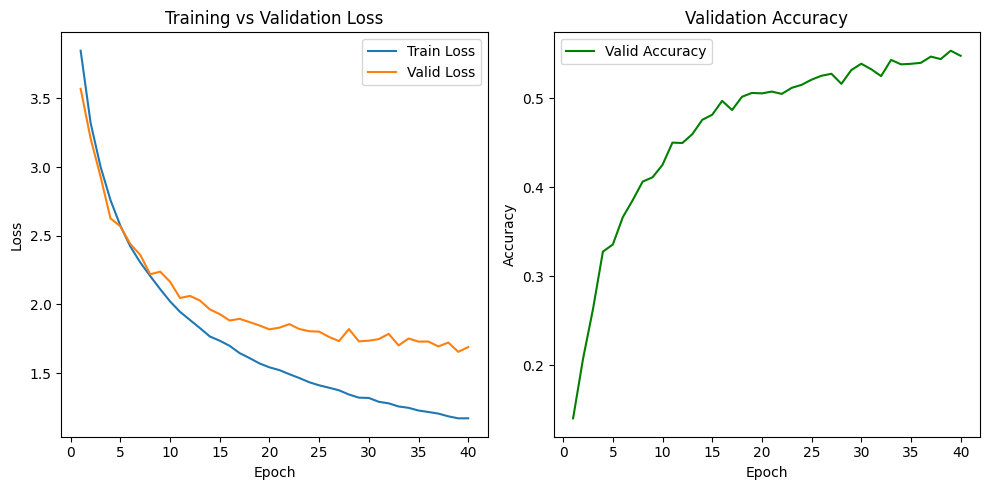

([3.847932360839844,
  3.3227571075439455,
  3.0040456497192385,
  2.7601761470794677,
  2.572780533027649,
  2.4220955636978148,
  2.305913499069214,
  2.2068724590301514,
  2.1118814670562744,
  2.0220427766799927,
  1.9462876661300659,
  1.8869339471817017,
  1.8281239379882812,
  1.7668021953582764,
  1.7360101081848145,
  1.6982038372039794,
  1.645532431602478,
  1.6093316047668458,
  1.5704791093826294,
  1.5420785044670104,
  1.5219031785964965,
  1.4921754270553589,
  1.4642533858299256,
  1.4337570421218873,
  1.41110369348526,
  1.3935628744125366,
  1.3749151579856873,
  1.3440224941253662,
  1.3213359266281128,
  1.3190007816314697,
  1.2911497079849243,
  1.2798980147361756,
  1.2569534392356874,
  1.2471338221549988,
  1.2276131335258484,
  1.216674561882019,
  1.2052141445159912,
  1.1853467166900635,
  1.170576235294342,
  1.1708891115188598],
 [3.570540241375091,
  3.2095456290396913,
  2.931730305313305,
  2.62734678596448,
  2.5687445394552437,
  2.439805531198052,


In [10]:
train_dataloader_model(model, train_loader, valid_loader, optim= optim, loss_fn= loss_fn)